In [1]:
#Module Import Section
import cv2
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow

import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.layers import ZeroPadding2D

<ipython-input-1-1b1fd5a77435>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Data path
fullpath_distinct_no = ('/content/drive/MyDrive/Spring 2023 Courses/CMPSC 442 AI/Project/brain_tumor_dataset/no/')
fullpath_distinct_yes = ('/content/drive/MyDrive/Spring 2023 Courses/CMPSC 442 AI/Project/brain_tumor_dataset/yes/')

In [4]:
#Obtain images(x) and labels(y)
#1=yes, 0=no
#resize images to (32,32)
x=[]
y=[]
os.chdir(fullpath_distinct_yes)
for each in tqdm(os.listdir()):
    img = cv2.imread(each)
    img = cv2.resize(img, (32, 32) )
    x.append(img)
    y.append(1)

  0%|          | 0/155 [00:00<?, ?it/s]

In [5]:
os.chdir(fullpath_distinct_no)
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (32, 32) )
    x.append(img)
    y.append(0)

  0%|          | 0/98 [00:00<?, ?it/s]

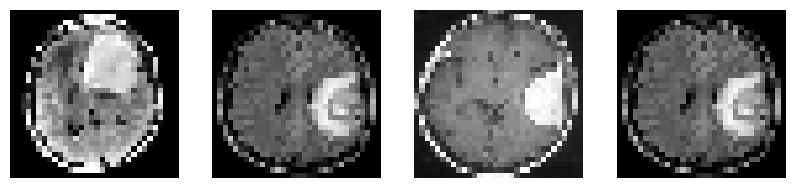

In [6]:
#Check images
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(x[i], cmap="gray")
  plt.axis('off')
plt.show()


In [7]:
X = np.squeeze(x)
X = X.astype('float32')
X /= 255

from sklearn.utils import shuffle
X,y  =  shuffle(X, y) #everything is shuffled, (test, valid, train) #and 1-1 correlated

In [8]:
#add percent based indexing on train and test 
p_train=0.8 #0.8 #0.9 #0.75 #0.7 #works well for 0.75-default 
i_train=int(len(y)*p_train)
i_valid=len(y)-i_train #ideally at 0.8

(x_train, y_train), (x_test, y_test) = (X[:i_train],y[:i_train]) , (X[i_train:] , y[i_train:])
(x_valid , y_valid) = (x_test[:i_valid], y_test[:i_valid])

In [9]:
#Preprocessing data
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test)

In [10]:
#VGG16 model sample
'''
model = tf.keras.Sequential()

# First layer - Conv 64 filters, kernel size 3, input img_size(224,224,1)
model.add(Conv2D(64, kernel_size = (3,3), padding="same", activation="relu", input_shape=(32,32,3)))
model.add(Conv2D(64, kernel_size = (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2,2)))'''

'''#Second layer
model.add(Conv2D(128, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(128, kernel_size = (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2,2)))'''

'''#Third layer
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2,2)))'''

'''#Fourth layer
model.add(Conv2D(512, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size = (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2,2)))'''

'''#Fifth layer
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size = (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2,2)))'''

'''#Sixth layer (Top)
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dense(4096, activation="relu"))
model.add(Dense(2, activation="softmax"))'''

'''model.build()
model.summary()'''

'model.build()\nmodel.summary()'

In [11]:
#Import VGG16
from keras.applications import vgg16

img_rows, img_cols = 32, 32

vgg = vgg16.VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (img_rows, img_cols, 3))

for layer in vgg.layers:
  layer.trainable = False

#Structure of VGG layers
for (i, layer) in enumerate(vgg.layers):
  print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [12]:
#Add layers to VGG16
top_layer = vgg.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dense(4096, activation='relu')(top_layer)
top_layer = Dense(4096, activation='relu')(top_layer)
top_layer = Dense(2, activation='softmax')(top_layer)


model = Model(inputs = vgg.input, outputs = top_layer)
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f2fc01fec10>>

In [13]:
#Model compile and fit
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc', 'binary_crossentropy', 'mean_squared_error'])

history = model.fit(x_train,
         y_train,
         epochs=20,
         validation_data=(x_test, y_test),
         verbose = 1,
         initial_epoch = 0)

Epoch 1/20
7/7 [==============================] - 9s 798ms/step - loss: 1.1753 - acc: 0.5396 - binary_crossentropy: 1.1753 - mean_squared_error: 0.3810 - val_loss: 0.4738 - val_acc: 0.7647 - val_binary_crossentropy: 0.4738 - val_mean_squared_error: 0.1754
Epoch 2/20
7/7 [==============================] - 4s 528ms/step - loss: 0.5313 - acc: 0.7475 - binary_crossentropy: 0.5313 - mean_squared_error: 0.1956 - val_loss: 0.3221 - val_acc: 0.9020 - val_binary_crossentropy: 0.3221 - val_mean_squared_error: 0.0759
Epoch 3/20
7/7 [==============================] - 5s 639ms/step - loss: 0.4526 - acc: 0.7624 - binary_crossentropy: 0.4526 - mean_squared_error: 0.1613 - val_loss: 0.3044 - val_acc: 0.9412 - val_binary_crossentropy: 0.3044 - val_mean_squared_error: 0.0621
Epoch 4/20
7/7 [==============================] - 4s 536ms/step - loss: 0.3848 - acc: 0.8218 - binary_crossentropy: 0.3848 - mean_squared_error: 0.1231 - val_loss: 0.3439 - val_acc: 0.8431 - val_binary_crossentropy: 0.3439 - val_mea

In [14]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test Binary Cross Entropy', score[2])
print('\n', 'Test Mean Squared Error:', score[3])


 Test accuracy: 0.8235294222831726

 Test Binary Cross Entropy 0.8326252698898315

 Test Mean Squared Error: 0.13794468343257904


Text(0.5, 1.0, 'Binary Cross Entropy (CE) (Train + Test vs. Epochs) - CNN')

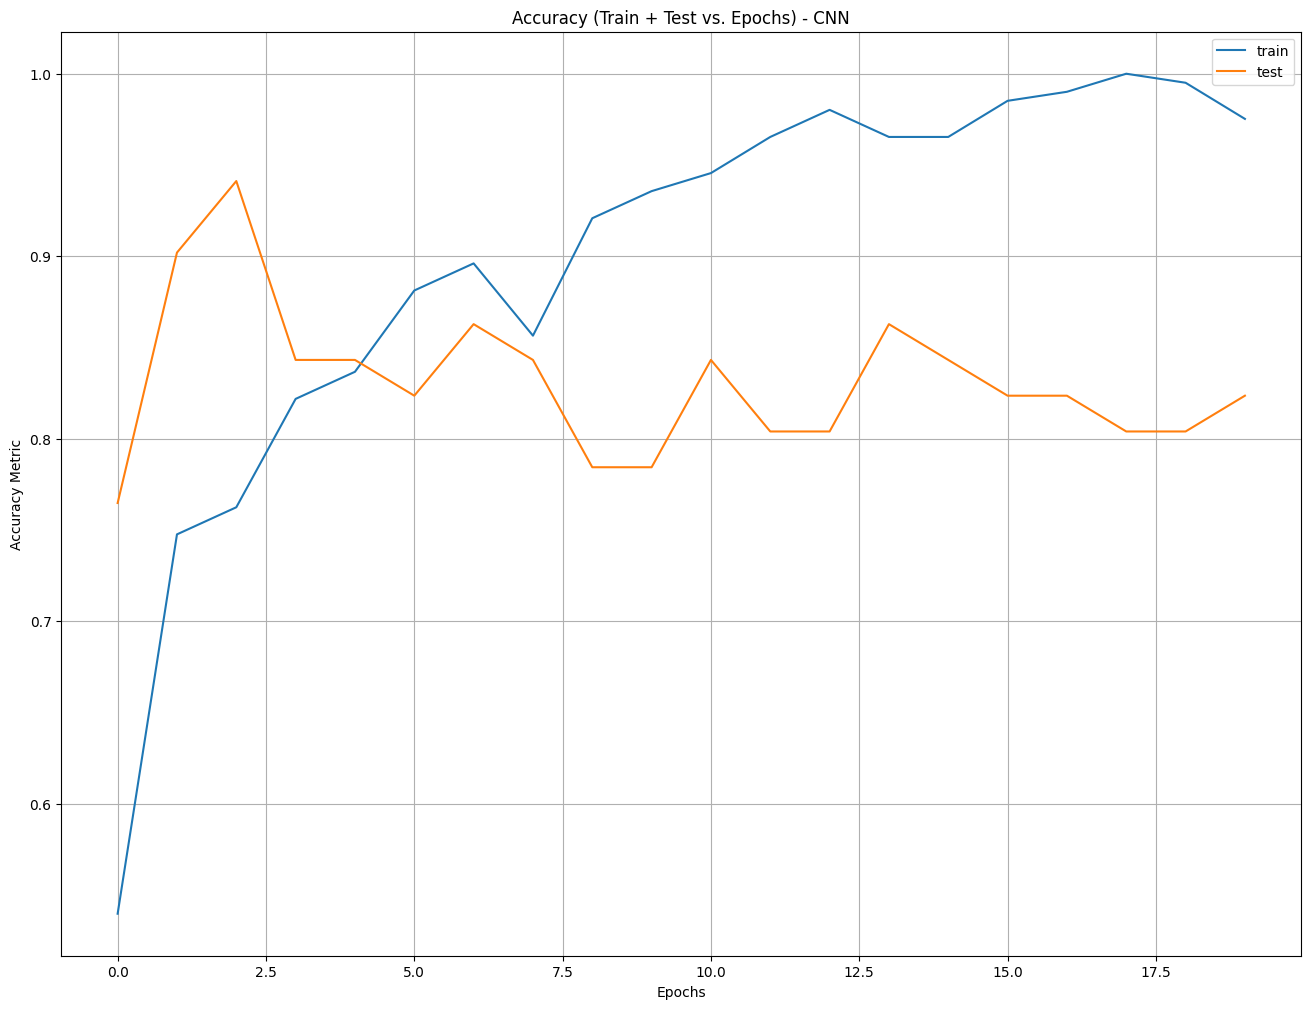

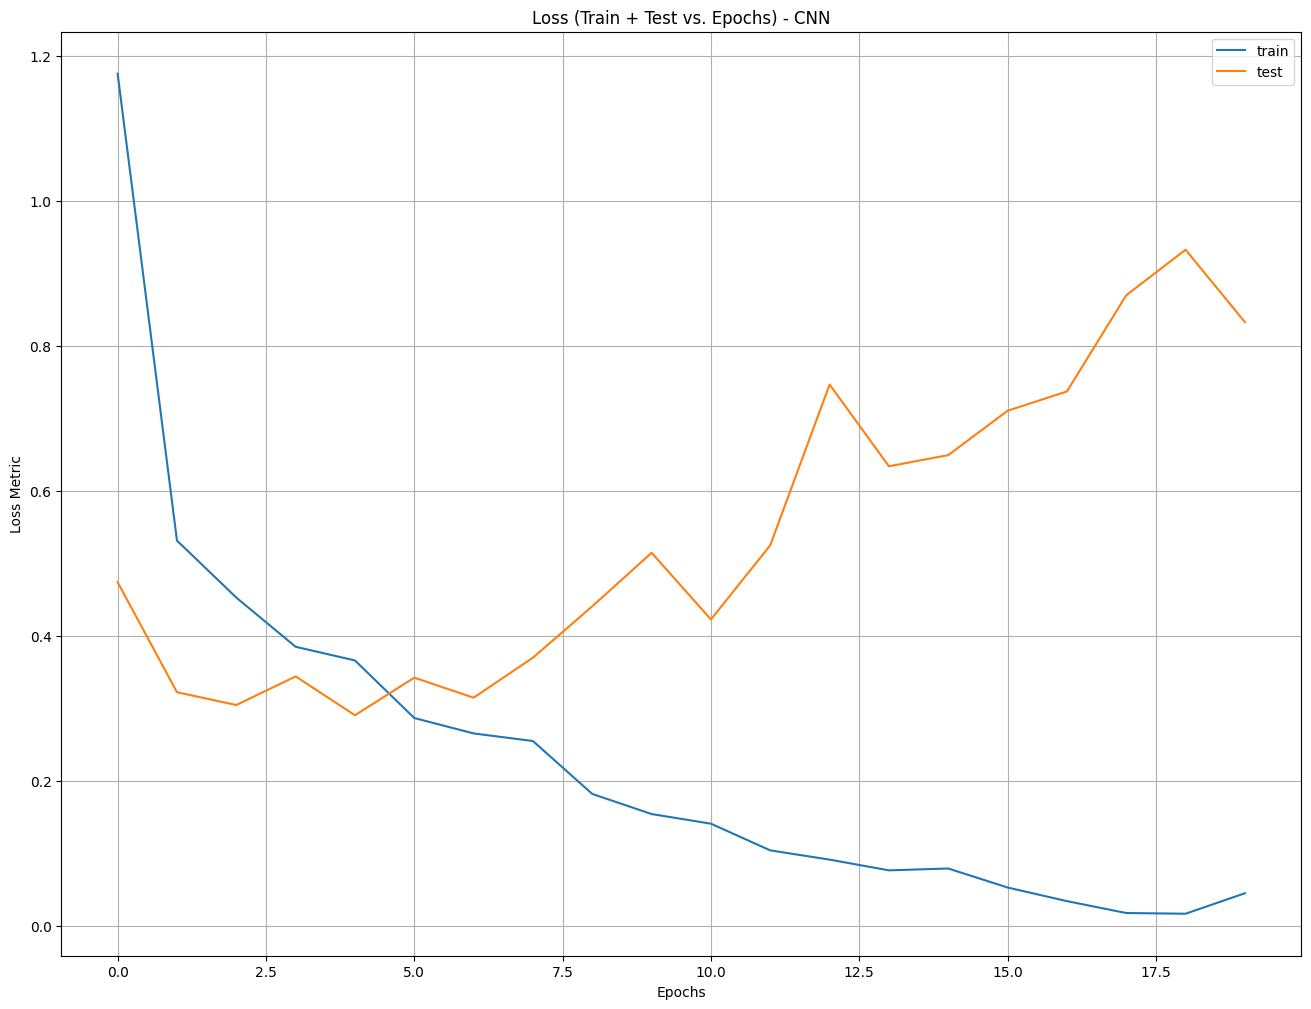

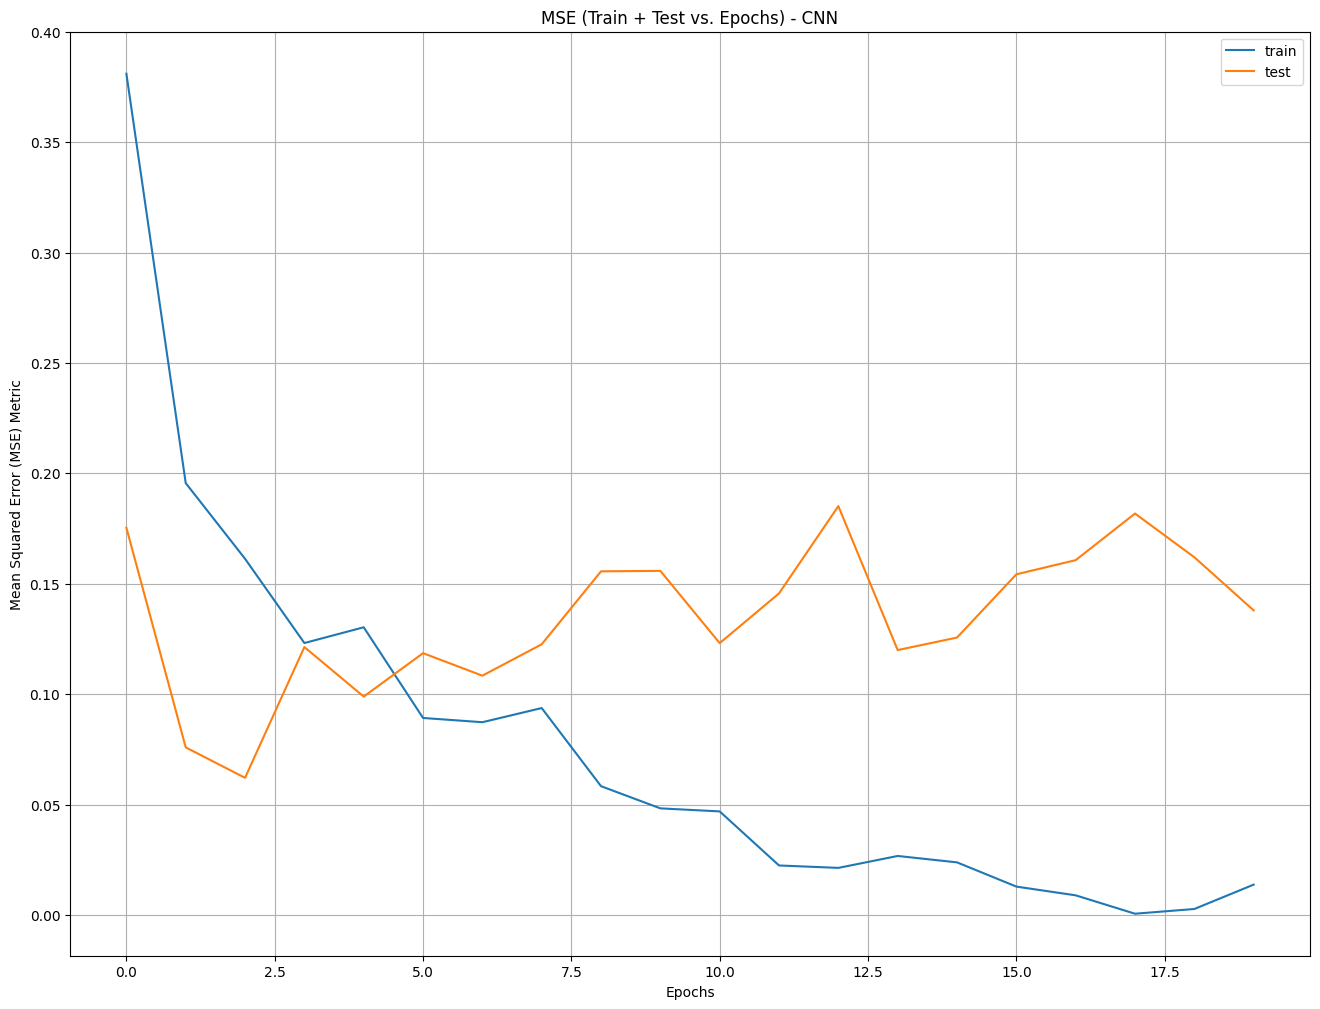

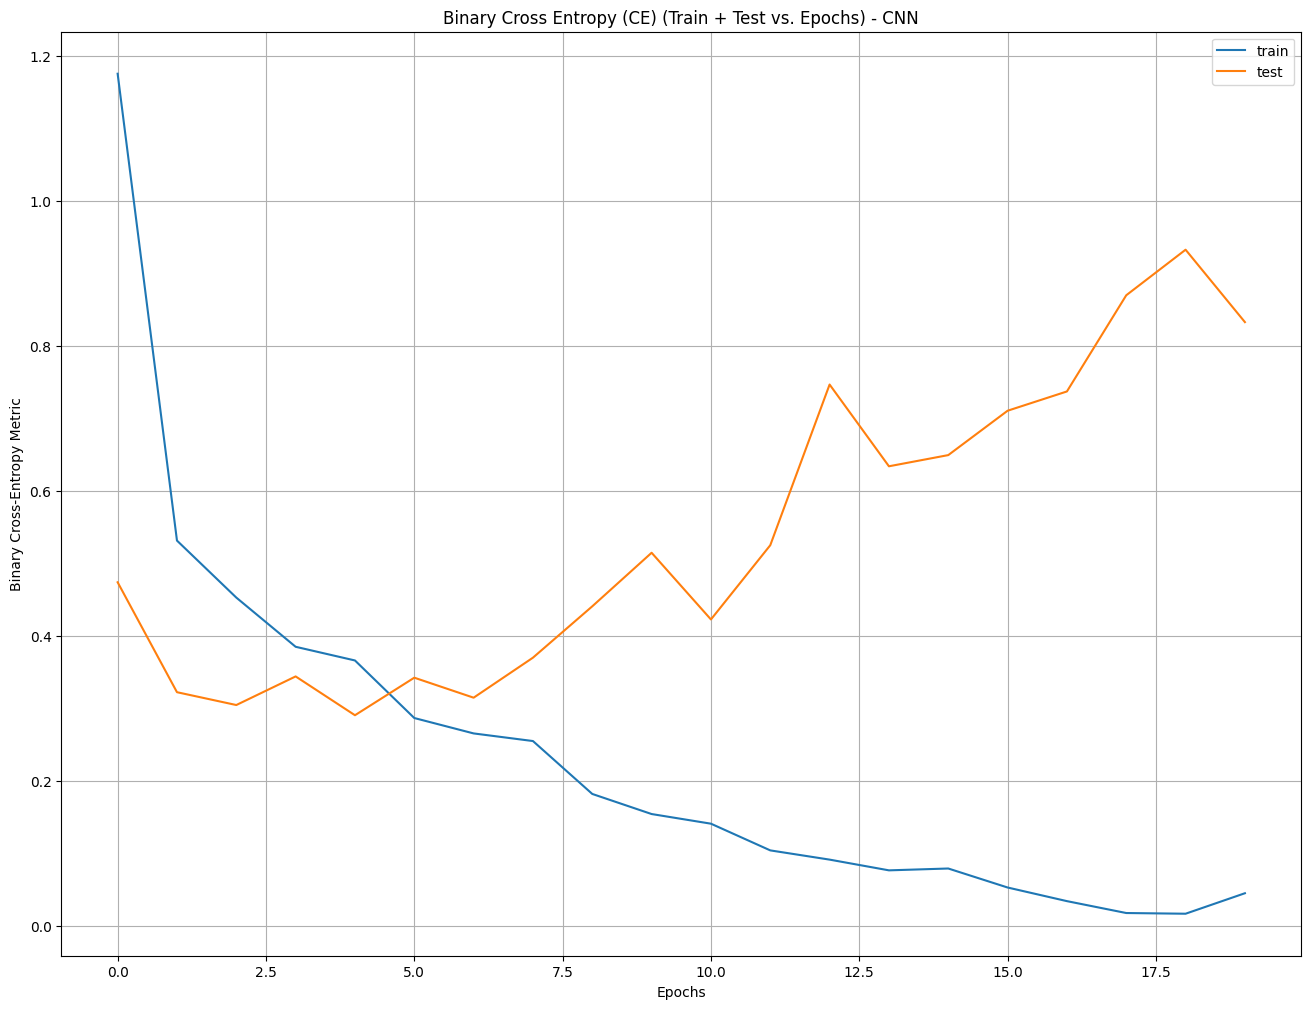

In [16]:
#Analysis and Plot Section

epochs_arr=np.arange(20)

y_acc_train=np.array(history.history["acc"])
y_loss_train=np.array(history.history["loss"])
y_mse_train=np.array(history.history["mean_squared_error"])
y_ce_train=np.array(history.history["binary_crossentropy"])

y_acc_test=np.array(history.history["val_acc"])
y_loss_test=np.array(history.history["val_loss"])
y_mse_test=np.array(history.history["val_mean_squared_error"])
y_ce_test=np.array(history.history["val_binary_crossentropy"])





fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_acc_train, label="train") 
plt.plot(epochs_arr, y_acc_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Accuracy (Train + Test vs. Epochs) - CNN")


#loss plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_loss_train, label="train") 
plt.plot(epochs_arr, y_loss_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Loss Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Loss (Train + Test vs. Epochs) - CNN")

#mse plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_mse_train, label="train") 
plt.plot(epochs_arr, y_mse_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE) Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("MSE (Train + Test vs. Epochs) - CNN")


# bce plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_ce_train, label="train") 
plt.plot(epochs_arr, y_ce_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Binary Cross Entropy (CE) (Train + Test vs. Epochs) - CNN")

2/2 [==============================] - 1s 297ms/step
              precision    recall  f1-score   support

         Yes       0.82      0.82      0.82        51
          No       0.82      0.82      0.82        51

    accuracy                           0.82       102
   macro avg       0.82      0.82      0.82       102
weighted avg       0.82      0.82      0.82       102



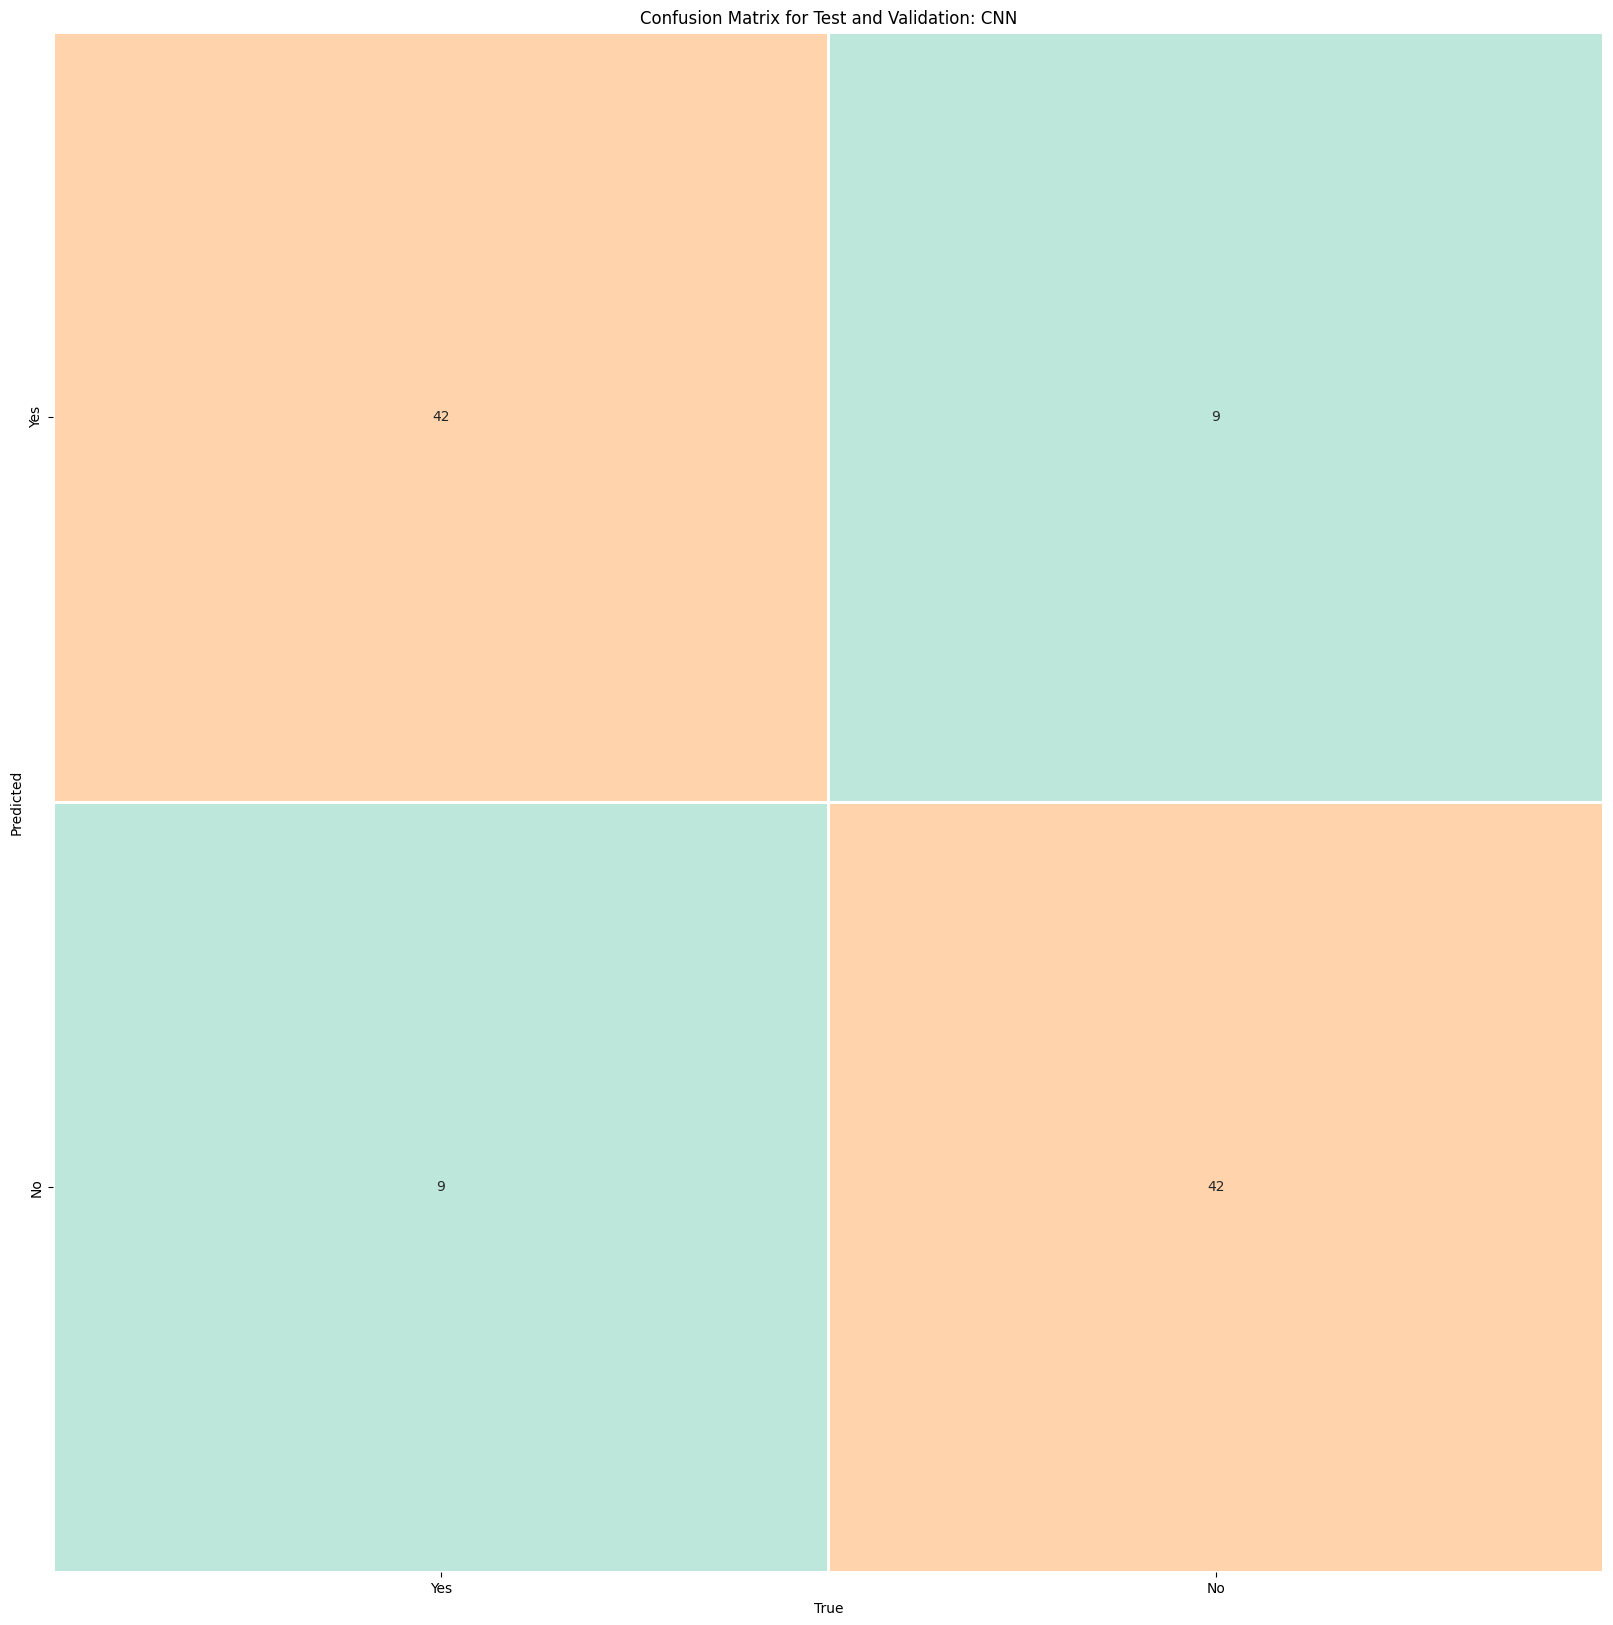

In [38]:
#Classification Report and Confusion Matrix
import seaborn as sns
from sklearn.metrics import classification_report
y_hat = model.predict(x_test)


labels =["Yes",  # index 0
        "No",      # index 1
        ]

df_cm = confusion_matrix((np.round(y_test.flatten())),(np.round(y_hat.flatten())))

plt.figure(figsize = (20,20))

sns.heatmap(df_cm, annot=True, cmap="icefire", linewidths=1, cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("True")
plt.title("Confusion Matrix for Test and Validation: CNN")
plt.ylabel("Predicted")

print(classification_report((np.round(y_test.flatten())),(np.round(y_hat.flatten())), target_names=labels))